In [750]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("Users_Cards_merged.csv")
cols_to_clean = ["per_capita_income", "yearly_income", "total_debt"]

for col in cols_to_clean:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(r"[^0-9.]", "", regex=True)  # strip $, commas
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")



df.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,4524.0,825.0,Visa,Debit,4.344677e+15,12/2022,623.0,YES,2.0,$24295,09/2002,2008.0,No,53.0,66.0,1966.0,11.0,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787.0,5.0
1,2731.0,825.0,Visa,Debit,4.956966e+15,12/2020,393.0,YES,2.0,$21968,04/2014,2014.0,No,53.0,66.0,1966.0,11.0,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787.0,5.0
2,3701.0,825.0,Visa,Debit,4.582313e+15,02/2024,719.0,YES,2.0,$46414,07/2003,2004.0,No,53.0,66.0,1966.0,11.0,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787.0,5.0
3,42.0,825.0,Visa,Credit,4.879494e+15,08/2024,693.0,NO,1.0,$12400,01/2003,2012.0,No,53.0,66.0,1966.0,11.0,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787.0,5.0
4,4659.0,825.0,Mastercard,Debit (Prepaid),5.722875e+15,03/2009,75.0,YES,1.0,$28,09/2008,2009.0,No,53.0,66.0,1966.0,11.0,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787.0,5.0


In [751]:
df["card_brand"].value_counts(normalize="True")*100

card_brand
Mastercard    52.212821
Visa          37.845753
Amex           6.540840
Discover       3.400586
Name: proportion, dtype: float64

In [752]:
# Median number of each card type per customer
medians = df["card_type"].value_counts().median()
print(medians)



2057.0


In [753]:


df["card_type"].value_counts(normalize="True")*100

card_type
Debit              57.126586
Credit             33.468923
Debit (Prepaid)     9.404491
Name: proportion, dtype: float64

In [754]:
card_types_overall = df["card_type"].value_counts(normalize="True")*100

card_types_overall_median = card_types_overall.median()
print(card_types_overall_median)


33.46892287666775


In [755]:
crosstab = pd.crosstab(df['card_brand'], df['card_type'])

print(crosstab)


card_type   Credit  Debit  Debit (Prepaid)
card_brand                                
Amex           402      0                0
Discover       209      0                0
Mastercard     635   2191              383
Visa           811   1320              195


In [756]:
# Raw counts
ct = pd.crosstab(df['card_brand'], df['card_type'])

# Row percentages
row_pct = pd.crosstab(df['card_brand'], df['card_type'], normalize='index') * 100

# Column percentages
col_pct = pd.crosstab(df['card_brand'], df['card_type'], normalize='columns') * 100

# Combine all into one table with multi-level columns
combined = pd.concat(
    {'Count': ct, 'Row%': row_pct.round(2), 'Col%': col_pct.round(2)},
    axis=1
)

# Print results
print("Counts:\n", ct, "\n")
print("Row %:\n", row_pct.round(2), "\n")
print("Column %:\n", col_pct.round(2), "\n")
print("Combined Table:\n", combined)


Counts:
 card_type   Credit  Debit  Debit (Prepaid)
card_brand                                
Amex           402      0                0
Discover       209      0                0
Mastercard     635   2191              383
Visa           811   1320              195 

Row %:
 card_type   Credit  Debit  Debit (Prepaid)
card_brand                                
Amex        100.00   0.00             0.00
Discover    100.00   0.00             0.00
Mastercard   19.79  68.28            11.94
Visa         34.87  56.75             8.38 

Column %:
 card_type   Credit  Debit  Debit (Prepaid)
card_brand                                
Amex         19.54    0.0             0.00
Discover     10.16    0.0             0.00
Mastercard   30.87   62.4            66.26
Visa         39.43   37.6            33.74 

Combined Table:
             Count                          Row%                          Col%  \
card_type  Credit Debit Debit (Prepaid)  Credit  Debit Debit (Prepaid) Credit   
card_brand   

In [757]:
print(df['credit_limit'].isna().sum())
print(df['credit_limit'].unique())



1
['$24295' '$21968' '$46414' ... '$2468' '$28074' nan]


In [758]:
df['credit_limit'] = pd.to_numeric(df['credit_limit'], errors='coerce')
median_limits = df.groupby('card_type')['credit_limit'].median()
print(median_limits)


card_type
Credit            NaN
Debit             NaN
Debit (Prepaid)   NaN
Name: credit_limit, dtype: float64


In [759]:
median_limits = df.groupby('card_type')['credit_limit'].median()
print(median_limits)


card_type
Credit            NaN
Debit             NaN
Debit (Prepaid)   NaN
Name: credit_limit, dtype: float64


In [760]:
def drop_sensitive_columns(df):
    # Define the columns you want to remove
    sensitive_cols = ["cvv", "card_on_dark_web", "birth_year", "address", "latitude", "longitude"]
    
    # Drop only those that exist in the DataFrame
    df = df.drop([col for col in sensitive_cols if col in df.columns], axis=1)
    
    return df

# Usage
df = drop_sensitive_columns(df)


In [761]:
df.head()

,id,client_id,card_brand,card_type,card_number,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,4524.0,825.0,Visa,Debit,4.344677e+15,12/2022,YES,2.0,NaN,09/2002,2008.0,53.0,66.0,11.0,Female,29278.0,59696.0,127613.0,787.0,5.0
1,2731.0,825.0,Visa,Debit,4.956966e+15,12/2020,YES,2.0,NaN,04/2014,2014.0,53.0,66.0,11.0,Female,29278.0,59696.0,127613.0,787.0,5.0
2,3701.0,825.0,Visa,Debit,4.582313e+15,02/2024,YES,2.0,NaN,07/2003,2004.0,53.0,66.0,11.0,Female,29278.0,59696.0,127613.0,787.0,5.0
3,42.0,825.0,Visa,Credit,4.879494e+15,08/2024,NO,1.0,NaN,01/2003,2012.0,53.0,66.0,11.0,Female,29278.0,59696.0,127613.0,787.0,5.0
4,4659.0,825.0,Mastercard,Debit (Prepaid),5.722875e+15,03/2009,YES,1.0,NaN,09/2008,2009.0,53.0,66.0,11.0,Female,29278.0,59696.0,127613.0,787.0,5.0


In [762]:
df.describe()

,id,client_id,card_number,num_cards_issued,credit_limit,year_pin_last_changed,current_age,retirement_age,birth_month,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
count,6146.000000,6146.000000,6.146000e+03,6146.000000,0.0,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000
mean,3072.500000,994.939636,4.820426e+15,1.503091,NaN,2013.436707,50.139766,66.544582,6.467296,23254.139440,45313.309795,57644.721445,718.252522,3.945005
std,1774.341709,578.614626,1.328582e+15,0.519191,NaN,4.270699,18.975960,3.455030,3.547927,11512.323216,23314.172216,51633.885249,63.227622,1.668031
min,0.000000,0.000000,3.001055e+14,1.000000,NaN,2002.000000,18.000000,50.000000,1.000000,0.000000,1.000000,0.000000,480.000000,1.000000
25%,1536.250000,492.250000,4.486365e+15,1.000000,NaN,2010.000000,35.000000,65.000000,3.000000,16844.000000,32295.000000,16803.000000,687.000000,3.000000
50%,3072.500000,992.000000,5.108957e+15,1.000000,NaN,2013.000000,50.000000,67.000000,7.000000,20646.500000,40251.000000,51529.500000,717.500000,4.000000
75%,4608.750000,1495.000000,5.585237e+15,2.000000,NaN,2017.000000,63.000000,69.000000,10.000000,26369.000000,52531.500000,84494.500000,760.000000,5.000000
max,6145.000000,1999.000000,6.997197e+15,3.000000,NaN,2020.000000,101.000000,79.000000,12.000000,163145.000000,307018.000000,516263.000000,850.000000,9.000000


In [763]:
df["client_id"].nunique()
df.shape[0]

6147

In [764]:
df.shape[0]

6147

In [765]:
df["current_age"].describe()

count    6146.000000
mean       50.139766
std        18.975960
min        18.000000
25%        35.000000
50%        50.000000
75%        63.000000
max       101.000000
Name: current_age, dtype: float64

In [766]:
# Common percentiles: 2
percentiles = df["current_age"].quantile([0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9])

df.to_excel("output.xlsx", index=False)



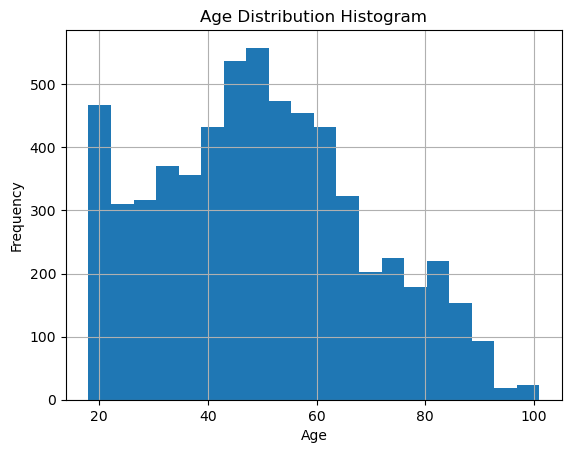

In [767]:
df["current_age"].hist(bins=20)
plt.title("Age Distribution Histogram")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


In [768]:
# Split ages into quartiles (4 groups)
age_bins = pd.qcut(df["current_age"], q=4)

# Count how many in each bin
counts = age_bins.value_counts().sort_index()
print(counts)


current_age
(17.999, 35.0]    1550
(35.0, 50.0]      1670
(50.0, 63.0]      1489
(63.0, 101.0]     1437
Name: count, dtype: int64


In [769]:
# Split ages into quartiles (4 groups)
age_bins = pd.qcut(df["current_age"], q=5)

# Count how many in each bin
counts = age_bins.value_counts().sort_index()
print(counts)


current_age
(17.999, 32.0]    1307
(32.0, 44.0]      1168
(44.0, 54.0]      1260
(54.0, 66.0]      1211
(66.0, 101.0]     1200
Name: count, dtype: int64


In [770]:
# Define custom bin edges
bins = [0, 30, 45, 60, df["current_age"].max()]

# Define labels for each bin
labels = ["≤30", "31–45", "46–60", "60+"]

# Create the binned age column
df["age_group"] = pd.cut(df["current_age"], bins=bins, labels=labels, include_lowest=True)

# Count how many in each bin
age_counts = df["age_group"].value_counts().sort_index()
print(age_counts)


age_group
≤30      1095
31–45    1459
46–60    1788
60+      1804
Name: count, dtype: int64


In [771]:
# Define custom bin edges
bins = [0, 30, 40, 50, 60, df["current_age"].max()]

# Define labels for each bin
labels = ["≤30", "31–40", "41-50", "51–60", "60+"]

# Create the binned age column
df["age_group"] = pd.cut(df["current_age"], bins=bins, labels=labels, include_lowest=True)

# Count how many in each bin
age_counts = df["age_group"].value_counts().sort_index()
print(age_counts)


age_group
≤30      1095
31–40     936
41-50    1189
51–60    1122
60+      1804
Name: count, dtype: int64


In [772]:
age_group_mapping = {
    "≤30": 1,
    "31–40": 2,
    "41-50": 3,
    "51–60": 4,
    "60+":5
}
df["age_group_order"] = df["age_group"].map(age_group_mapping)

In [773]:
df["age_group_order"].value_counts().sort_index()

age_group_order
1    1095
2     936
3    1189
4    1122
5    1804
Name: count, dtype: int64

In [774]:
df["age_group_order"].dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True, categories_dtype=int64)

In [775]:
df.head(30)

,id,client_id,card_brand,card_type,card_number,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,age_group,age_group_order
0,4524.0,825.0,Visa,Debit,4.344677e+15,12/2022,YES,2.0,NaN,09/2002,2008.0,53.0,66.0,11.0,Female,29278.0,59696.0,127613.0,787.0,5.0,51–60,4
1,2731.0,825.0,Visa,Debit,4.956966e+15,12/2020,YES,2.0,NaN,04/2014,2014.0,53.0,66.0,11.0,Female,29278.0,59696.0,127613.0,787.0,5.0,51–60,4
2,3701.0,825.0,Visa,Debit,4.582313e+15,02/2024,YES,2.0,NaN,07/2003,2004.0,53.0,66.0,11.0,Female,29278.0,59696.0,127613.0,787.0,5.0,51–60,4
3,42.0,825.0,Visa,Credit,4.879494e+15,08/2024,NO,1.0,NaN,01/2003,2012.0,53.0,66.0,11.0,Female,29278.0,59696.0,127613.0,787.0,5.0,51–60,4
4,4659.0,825.0,Mastercard,Debit (Prepaid),5.722875e+15,03/2009,YES,1.0,NaN,09/2008,2009.0,53.0,66.0,11.0,Female,29278.0,59696.0,127613.0,787.0,5.0,51–60,4
5,4537.0,1746.0,Visa,Credit,4.404899e+15,09/2003,YES,1.0,NaN,09/2003,2012.0,53.0,68.0,12.0,Female,37891.0,77254.0,191349.0,701.0,5.0,51–60,4
6,1278.0,1746.0,Visa,Debit,4.001483e+15,07/2022,YES,2.0,NaN,02/2011,2011.0,53.0,68.0,12.0,Female,37891.0,77254.0,191349.0,701.0,5.0,51–60,4
7,3687.0,1746.0,Mastercard,Debit,5.627221e+15,06/2022,YES,2.0,NaN,07/2003,2015.0,53.0,68.0,12.0,Female,37891.0,77254.0,191349.0,701.0,5.0,51–60,4
8,3465.0,1746.0,Mastercard,Debit (Prepaid),5.711382e+15,11/2020,YES,2.0,NaN,06/2010,2015.0,53.0,68.0,12.0,Female,37891.0,77254.0,191349.0,701.0,5.0,51–60,4
9,3754.0,1746.0,Mastercard,Debit (Prepaid),5.766122e+15,02/2023,YES,1.0,NaN,07/2006,2012.0,53.0,68.0,12.0,Female,37891.0,77254.0,191349.0,701.0,5.0,51–60,4


In [776]:
df.describe()


,id,client_id,card_number,num_cards_issued,credit_limit,year_pin_last_changed,current_age,retirement_age,birth_month,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
count,6146.000000,6146.000000,6.146000e+03,6146.000000,0.0,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000
mean,3072.500000,994.939636,4.820426e+15,1.503091,NaN,2013.436707,50.139766,66.544582,6.467296,23254.139440,45313.309795,57644.721445,718.252522,3.945005
std,1774.341709,578.614626,1.328582e+15,0.519191,NaN,4.270699,18.975960,3.455030,3.547927,11512.323216,23314.172216,51633.885249,63.227622,1.668031
min,0.000000,0.000000,3.001055e+14,1.000000,NaN,2002.000000,18.000000,50.000000,1.000000,0.000000,1.000000,0.000000,480.000000,1.000000
25%,1536.250000,492.250000,4.486365e+15,1.000000,NaN,2010.000000,35.000000,65.000000,3.000000,16844.000000,32295.000000,16803.000000,687.000000,3.000000
50%,3072.500000,992.000000,5.108957e+15,1.000000,NaN,2013.000000,50.000000,67.000000,7.000000,20646.500000,40251.000000,51529.500000,717.500000,4.000000
75%,4608.750000,1495.000000,5.585237e+15,2.000000,NaN,2017.000000,63.000000,69.000000,10.000000,26369.000000,52531.500000,84494.500000,760.000000,5.000000
max,6145.000000,1999.000000,6.997197e+15,3.000000,NaN,2020.000000,101.000000,79.000000,12.000000,163145.000000,307018.000000,516263.000000,850.000000,9.000000


In [777]:
# To get the dtypes for each column, use df.dtypes
print(df.dtypes)



id                        float64
client_id                 float64
card_brand                 object
card_type                  object
card_number               float64
expires                    object
has_chip                   object
num_cards_issued          float64
credit_limit              float64
acct_open_date             object
year_pin_last_changed     float64
current_age               float64
retirement_age            float64
birth_month               float64
gender                     object
per_capita_income         float64
yearly_income             float64
total_debt                float64
credit_score              float64
num_credit_cards          float64
age_group                category
age_group_order          category
dtype: object


In [778]:
df["age_group"].unique()

['51–60', '60+', '41-50', '31–40', '≤30', NaN]
Categories (5, object): ['≤30' < '31–40' < '41-50' < '51–60' < '60+']

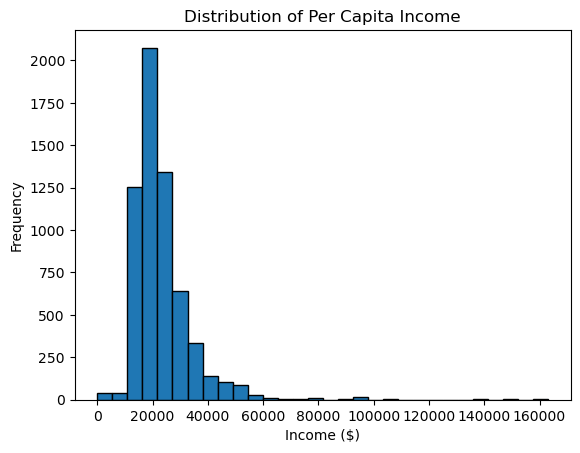

In [779]:
df["per_capita_income"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("Distribution of Per Capita Income")
plt.xlabel("Income ($)")
plt.show()

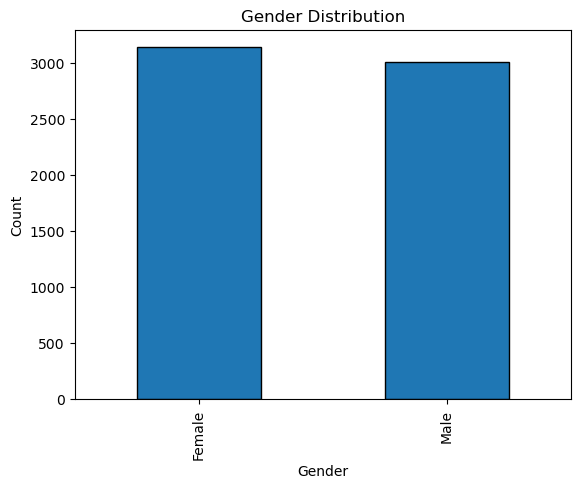

In [780]:
# Fairly even distribution of age
df["gender"].value_counts().plot(kind="bar", edgecolor="black")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


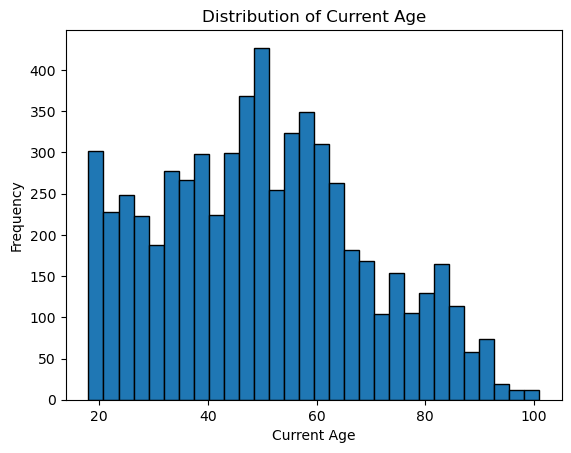

In [781]:
df["current_age"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("Distribution of Current Age")
plt.xlabel("Current Age")
plt.show()

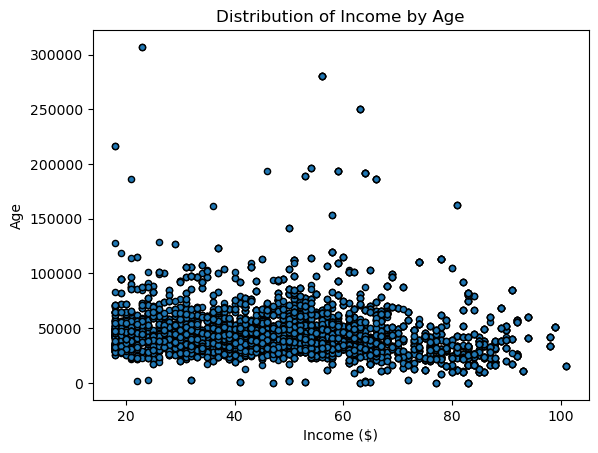

In [782]:
df.plot(kind="scatter", y="yearly_income", x="current_age", edgecolor="black")
plt.title("Distribution of Income by Age")
plt.xlabel("Income ($)")
plt.ylabel("Age")
plt.show()


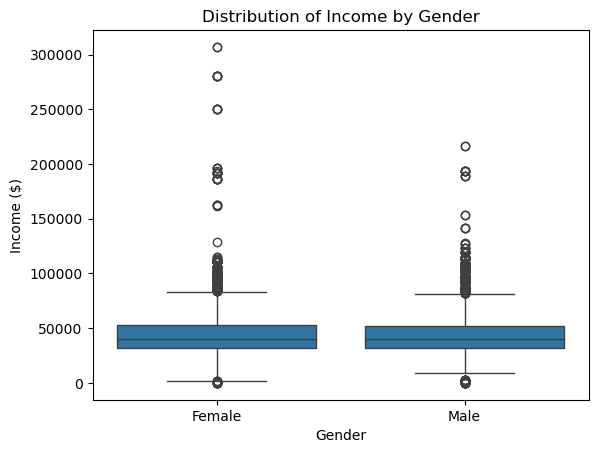

In [783]:
sns.boxplot(x="gender", y="yearly_income", data=df)
plt.title("Distribution of Income by Gender")
plt.xlabel("Gender")
plt.ylabel("Income ($)")
plt.show()




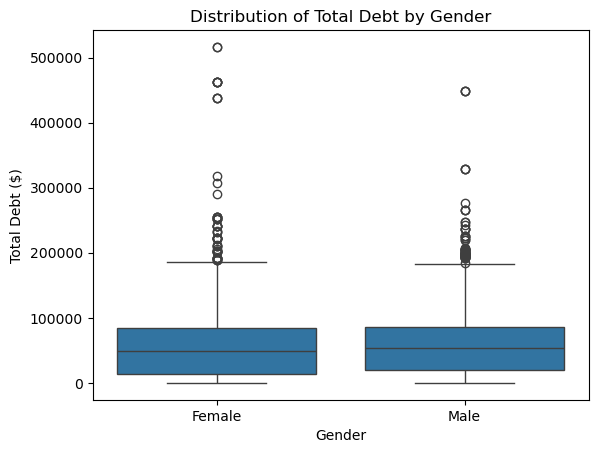

In [784]:
sns.boxplot(x="gender", y="total_debt", data=df)
plt.title("Distribution of Total Debt by Gender")
plt.xlabel("Gender")
plt.ylabel("Total Debt ($)")
plt.show()

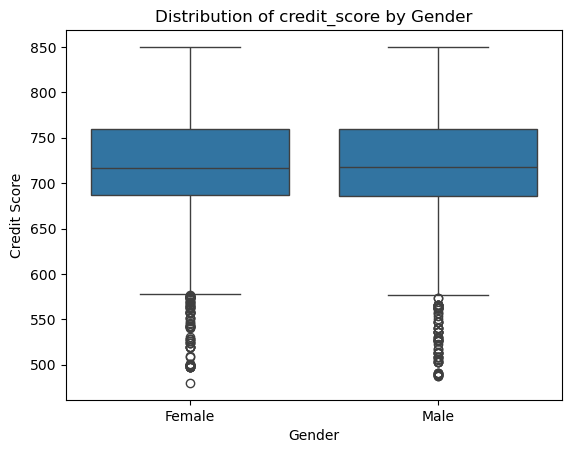

In [785]:
sns.boxplot(x="gender", y="credit_score", data=df)
plt.title("Distribution of credit_score by Gender")
plt.xlabel("Gender")
plt.ylabel("Credit Score")
plt.show()


In [786]:
# Assuming this Credit Score is the FICO Score (arange 300-850: 300-579: Poor, 580-669: Fair; 670-739: Good; 740-799: Very Good; 800-850: Exceptional) )

In [787]:
bins = [300, 580, 670, 740, 800, 851]  
labels = ["Poor", "Fair", "Good", "Very_Good", "Exceptional"]

df["credit_score_group"] = pd.cut(df["credit_score"], bins=bins, labels=labels, right=False)


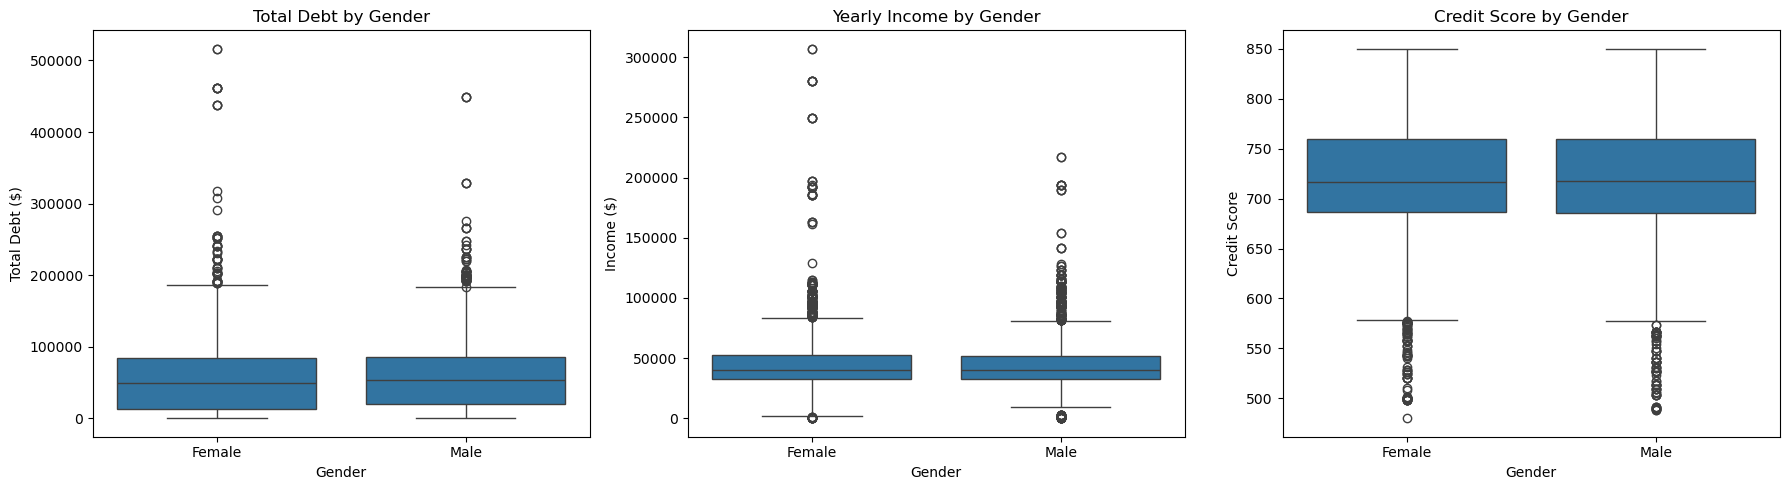

In [788]:
# Create a row of 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 colum

# First boxplot: Total Debt
sns.boxplot(x="gender", y="total_debt", data=df, ax=axes[0])
axes[0].set_title("Total Debt by Gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Total Debt ($)")

# Second boxplot: Yearly Income
sns.boxplot(x="gender", y="yearly_income", data=df, ax=axes[1])
axes[1].set_title("Yearly Income by Gender")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Income ($)")

# Third boxplot: Credit Score
sns.boxplot(x="gender", y="credit_score", data=df, ax=axes[2])
axes[2].set_title("Credit Score by Gender")
axes[2].set_xlabel("Gender")
axes[2].set_ylabel("Credit Score")

plt.tight_layout()
plt.show()




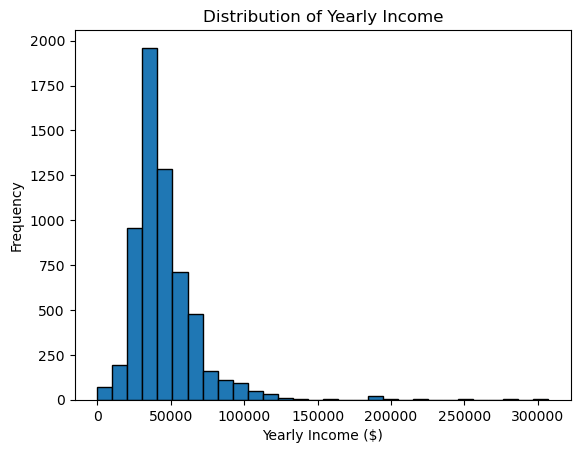

In [789]:
df["yearly_income"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("Distribution of Yearly Income")
plt.xlabel("Yearly Income ($)")
plt.show()

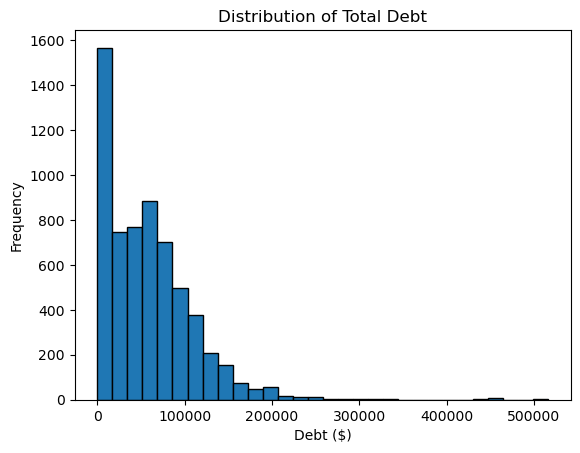

In [790]:
df["total_debt"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("Distribution of Total Debt")
plt.xlabel("Debt ($)")
plt.show()

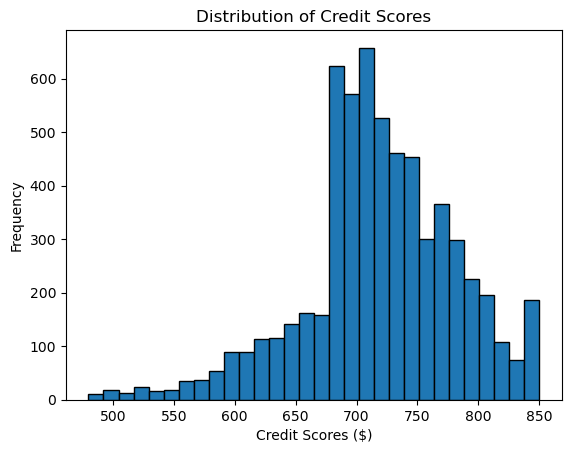

In [791]:
df["credit_score"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("Distribution of Credit Scores")
plt.xlabel("Credit Scores ($)")
plt.show()

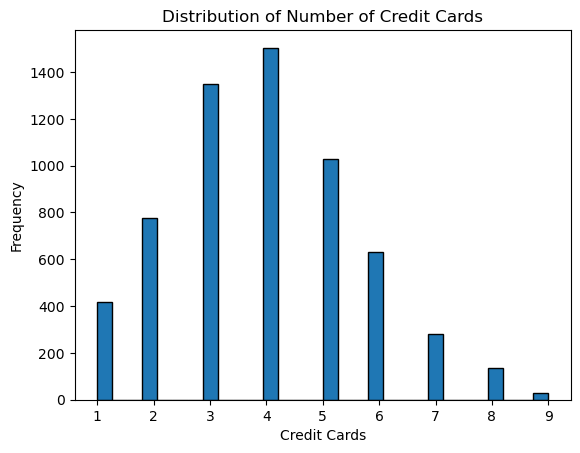

In [792]:
df["num_credit_cards"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("Distribution of Number of Credit Cards")
plt.xlabel("Credit Cards")
plt.show()

In [793]:
df.describe(include="all")


,id,client_id,card_brand,card_type,card_number,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,current_age,retirement_age,birth_month,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,age_group,age_group_order,credit_score_group
count,6146.000000,6146.000000,6146,6146,6.146000e+03,6146,6146,6146.000000,0.0,6146,6146.000000,6146.000000,6146.000000,6146.000000,6146,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000,6146,6146.0,6146
unique,NaN,NaN,4,3,NaN,259,2,NaN,NaN,303,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,5,5.0,5
top,NaN,NaN,Mastercard,Debit,NaN,02/2020,YES,NaN,NaN,02/2020,NaN,NaN,NaN,NaN,Female,NaN,NaN,NaN,NaN,NaN,60+,5.0,Good
freq,NaN,NaN,3209,3511,NaN,377,5500,NaN,NaN,607,NaN,NaN,NaN,NaN,3139,NaN,NaN,NaN,NaN,NaN,1804,1804.0,2984
mean,3072.500000,994.939636,NaN,NaN,4.820426e+15,NaN,NaN,1.503091,NaN,NaN,2013.436707,50.139766,66.544582,6.467296,NaN,23254.139440,45313.309795,57644.721445,718.252522,3.945005,NaN,NaN,NaN
std,1774.341709,578.614626,NaN,NaN,1.328582e+15,NaN,NaN,0.519191,NaN,NaN,4.270699,18.975960,3.455030,3.547927,NaN,11512.323216,23314.172216,51633.885249,63.227622,1.668031,NaN,NaN,NaN
min,0.000000,0.000000,NaN,NaN,3.001055e+14,NaN,NaN,1.000000,NaN,NaN,2002.000000,18.000000,50.000000,1.000000,NaN,0.000000,1.000000,0.000000,480.000000,1.000000,NaN,NaN,NaN
25%,1536.250000,492.250000,NaN,NaN,4.486365e+15,NaN,NaN,1.000000,NaN,NaN,2010.000000,35.000000,65.000000,3.000000,NaN,16844.000000,32295.000000,16803.000000,687.000000,3.000000,NaN,NaN,NaN
50%,3072.500000,992.000000,NaN,NaN,5.108957e+15,NaN,NaN,1.000000,NaN,NaN,2013.000000,50.000000,67.000000,7.000000,NaN,20646.500000,40251.000000,51529.500000,717.500000,4.000000,NaN,NaN,NaN
75%,4608.750000,1495.000000,NaN,NaN,5.585237e+15,NaN,NaN,2.000000,NaN,NaN,2017.000000,63.000000,69.000000,10.000000,NaN,26369.000000,52531.500000,84494.500000,760.000000,5.000000,NaN,NaN,NaN


In [794]:
# No difference gender vs credit score
male_amounts = df.loc[df["gender"] == "Male", "credit_score"]
female_amounts = df.loc[df["gender"] == "Female", "credit_score"]
t_stat, p_val = stats.ttest_ind(male_amounts, female_amounts, nan_policy="omit")
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")
print("Male mean:", male_amounts.mean())
print("Female mean:", female_amounts.mean())
print("Male std:", male_amounts.std())
print("Female std:", female_amounts.std())




T-statistic: 0.652, p-value: 0.514
Male mean: 718.789823744596
Female mean: 717.737814590634
Male std: 62.71017400991251
Female std: 63.72510879213781


In [795]:
# No difference gender x number of credit cards
male_amounts = df.loc[df["gender"] == "Male", "num_credit_cards"]
female_amounts = df.loc[df["gender"] == "Female", "num_credit_cards"]
t_stat, p_val = stats.ttest_ind(male_amounts, female_amounts, nan_policy="omit")
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")
print("Male mean:", male_amounts.mean())
print("Female mean:", female_amounts.mean())
print("Male std:", male_amounts.std())
print("Female std:", female_amounts.std())


T-statistic: -2.382, p-value: 0.017
Male mean: 3.893249085467243
Female mean: 3.9945842625039822
Male std: 1.608850785636749
Female std: 1.7216156548029298


In [796]:
print(df["per_capita_income"].unique()[:20])



[ 29278.  37891.  22681. 163145.  53797.  20599.  25258.  26790.  26273.
  18730.  27548.  22427.  33914.  20325.  10059.  11342.  17898.  21950.
  26481.  17460.]


In [797]:
df["gender_encoded"] = df["gender"].map({"Male": 0, "Female": 1})


In [798]:
df["gender_encoded"].dtype

dtype('float64')

In [799]:
print(df.dtypes)

id                        float64
client_id                 float64
card_brand                 object
card_type                  object
card_number               float64
expires                    object
has_chip                   object
num_cards_issued          float64
credit_limit              float64
acct_open_date             object
year_pin_last_changed     float64
current_age               float64
retirement_age            float64
birth_month               float64
gender                     object
per_capita_income         float64
yearly_income             float64
total_debt                float64
credit_score              float64
num_credit_cards          float64
age_group                category
age_group_order          category
credit_score_group       category
gender_encoded            float64
dtype: object


In [800]:
print(df[cols_to_clean].dtypes)       # should all be float64
print(df[cols_to_clean].head())       # should show numbers or NaN
print(df[cols_to_clean].describe())   # should show proper stats


per_capita_income    float64
yearly_income        float64
total_debt           float64
dtype: object
   per_capita_income  yearly_income  total_debt
0            29278.0        59696.0    127613.0
1            29278.0        59696.0    127613.0
2            29278.0        59696.0    127613.0
3            29278.0        59696.0    127613.0
4            29278.0        59696.0    127613.0
       per_capita_income  yearly_income     total_debt
count        6146.000000    6146.000000    6146.000000
mean        23254.139440   45313.309795   57644.721445
std         11512.323216   23314.172216   51633.885249
min             0.000000       1.000000       0.000000
25%         16844.000000   32295.000000   16803.000000
50%         20646.500000   40251.000000   51529.500000
75%         26369.000000   52531.500000   84494.500000
max        163145.000000  307018.000000  516263.000000


In [801]:
# No difference gender vs Yearly Income
male_amounts = df.loc[df["gender"] == "Male", "yearly_income"]
female_amounts = df.loc[df["gender"] == "Female", "yearly_income"]

t_stat, p_val = stats.ttest_ind(male_amounts, female_amounts, nan_policy="omit")
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")
print("Male mean:", male_amounts.mean())
print("Female mean:", female_amounts.mean())
print("Male std:", male_amounts.std())
print("Female std:", female_amounts.std())


T-statistic: -1.094, p-value: 0.274
Male mean: 44980.75823079481
Female mean: 45631.87703090156
Male std: 21085.843380357255
Female std: 25264.448630473362


In [802]:
# No difference gender vs total debt
male_amounts = df.loc[df["gender"] == "Male", "total_debt"]
female_amounts = df.loc[df["gender"] == "Female", "total_debt"]

t_stat, p_val = stats.ttest_ind(male_amounts, female_amounts, nan_policy="omit")
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")
print("Male mean:", male_amounts.mean())
print("Female mean:", female_amounts.mean())
print("Male std:", male_amounts.std())
print("Female std:", female_amounts.std())


T-statistic: 2.048, p-value: 0.041
Male mean: 59022.581642833386
Female mean: 56324.80248486779
Male std: 49929.378542443665
Female std: 53190.02626962969


In [803]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6147 entries, 0 to 6146
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     6146 non-null   float64 
 1   client_id              6146 non-null   float64 
 2   card_brand             6146 non-null   object  
 3   card_type              6146 non-null   object  
 4   card_number            6146 non-null   float64 
 5   expires                6146 non-null   object  
 6   has_chip               6146 non-null   object  
 7   num_cards_issued       6146 non-null   float64 
 8   credit_limit           0 non-null      float64 
 9   acct_open_date         6146 non-null   object  
 10  year_pin_last_changed  6146 non-null   float64 
 11  current_age            6146 non-null   float64 
 12  retirement_age         6146 non-null   float64 
 13  birth_month            6146 non-null   float64 
 14  gender                 6146 non-null   o

In [804]:
numeric_cols = df.select_dtypes(include="number").columns
print(numeric_cols)


Index(['id', 'client_id', 'card_number', 'num_cards_issued', 'credit_limit',
       'year_pin_last_changed', 'current_age', 'retirement_age', 'birth_month',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'gender_encoded'],
      dtype='object')


In [805]:
corr_matrix = df.corr(numeric_only=True)
print("Rows:", corr_matrix.index.tolist())
print("Columns:", corr_matrix.columns.tolist())


Rows: ['id', 'client_id', 'card_number', 'num_cards_issued', 'credit_limit', 'year_pin_last_changed', 'current_age', 'retirement_age', 'birth_month', 'per_capita_income', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards', 'gender_encoded']
Columns: ['id', 'client_id', 'card_number', 'num_cards_issued', 'credit_limit', 'year_pin_last_changed', 'current_age', 'retirement_age', 'birth_month', 'per_capita_income', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards', 'gender_encoded']


In [806]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
print(corr_matrix)



                             id  client_id  card_number  num_cards_issued  \
id                     1.000000   0.018311     0.017332         -0.023691   
client_id              0.018311   1.000000     0.000362         -0.013465   
card_number            0.017332   0.000362     1.000000         -0.005381   
num_cards_issued      -0.023691  -0.013465    -0.005381          1.000000   
credit_limit                NaN        NaN          NaN               NaN   
year_pin_last_changed -0.381234  -0.009708    -0.013152         -0.013599   
current_age            0.286161   0.018656     0.016688          0.015623   
retirement_age         0.031111  -0.016904     0.015218         -0.058863   
birth_month            0.001180  -0.016871     0.006965         -0.006085   
per_capita_income      0.003075   0.065391    -0.007916         -0.007548   
yearly_income         -0.014294   0.051388    -0.004808         -0.008403   
total_debt            -0.073058   0.046071    -0.020816          0.019417   

In [807]:
df.columns.to_list()

['id',
 'client_id',
 'card_brand',
 'card_type',
 'card_number',
 'expires',
 'has_chip',
 'num_cards_issued',
 'credit_limit',
 'acct_open_date',
 'year_pin_last_changed',
 'current_age',
 'retirement_age',
 'birth_month',
 'gender',
 'per_capita_income',
 'yearly_income',
 'total_debt',
 'credit_score',
 'num_credit_cards',
 'age_group',
 'age_group_order',
 'credit_score_group',
 'gender_encoded']

In [808]:
card_brand.nunique()

NameError: name 'card_brand' is not defined

            Count  Proportion  Proportion (%)
card_brand                                   
Mastercard   3209    0.522128           52.21
Visa         2326    0.378458           37.85
Amex          402    0.065408            6.54
Discover      209    0.034006            3.40


<Axes: title={'center': 'Card Brand Proportion'}, ylabel='Proportion'>

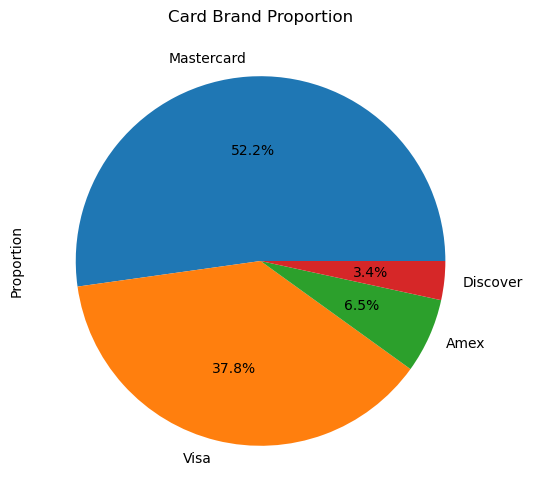

In [ ]:
# Count and proportion
brand_counts = df["card_brand"].value_counts()
brand_proportions = df["card_brand"].value_counts(normalize=True)

# Combine into one DataFrame
brand_summary = pd.DataFrame({
    "Count": brand_counts,
    "Proportion": brand_proportions
})

# Optional: convert proportions to percentages
brand_summary["Proportion (%)"] = (brand_summary["Proportion"] * 100).round(2)

print(brand_summary)
brand_summary["Proportion"].plot(kind="pie", 
                                 autopct="%1.1f%%", 
                                 figsize=(6,6), 
                                 title="Card Brand Proportion")




In [ ]:
# Count how many cards of each brand
brand_counts = df["card_brand"].value_counts()
print(brand_counts)

# Proportion of each brand
brand_proportions = df["card_brand"].value_counts(normalize=True)
print(brand_proportions)

# Sum of proportions (should equal 1.0)
print(brand_proportions.sum())





card_brand
Mastercard    3209
Visa          2326
Amex           402
Discover       209
Name: count, dtype: int64
card_brand
Mastercard    0.522128
Visa          0.378458
Amex          0.065408
Discover      0.034006
Name: proportion, dtype: float64
1.0


In [ ]:
print(df.dtypes)

id                        float64
client_id                 float64
card_brand                 object
card_type                  object
card_number               float64
expires                    object
has_chip                   object
num_cards_issued          float64
credit_limit              float64
acct_open_date             object
year_pin_last_changed     float64
current_age               float64
retirement_age            float64
birth_month               float64
gender                     object
per_capita_income         float64
yearly_income             float64
total_debt                float64
credit_score              float64
num_credit_cards          float64
age_group                category
age_group_order          category
credit_score_group       category
gender_encoded            float64
dtype: object


In [ ]:
df.drop(["age_group"], axis=1, inplace=True)

In [809]:
print(df.dtypes)

id                        float64
client_id                 float64
card_brand                 object
card_type                  object
card_number               float64
expires                    object
has_chip                   object
num_cards_issued          float64
credit_limit              float64
acct_open_date             object
year_pin_last_changed     float64
current_age               float64
retirement_age            float64
birth_month               float64
gender                     object
per_capita_income         float64
yearly_income             float64
total_debt                float64
credit_score              float64
num_credit_cards          float64
age_group                category
age_group_order          category
credit_score_group       category
gender_encoded            float64
dtype: object


In [815]:
# Correct usage
df = df.drop(["expires", "has_chip", "acct_open_date", "age_group"], axis=1)


In [817]:
print(df.dtypes)

id                        float64
client_id                 float64
card_brand                 object
card_type                  object
card_number               float64
num_cards_issued          float64
credit_limit              float64
year_pin_last_changed     float64
current_age               float64
retirement_age            float64
birth_month               float64
gender                     object
per_capita_income         float64
yearly_income             float64
total_debt                float64
credit_score              float64
num_credit_cards          float64
age_group_order          category
credit_score_group       category
gender_encoded            float64
dtype: object


In [819]:
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

category_mappings = {}
for col in categorical_cols:
    df[col] = df[col].astype("category")
    category_mappings[col] = dict(enumerate(df[col].cat.categories))
    df[col] = df[col].cat.codes


In [821]:
print(df.dtypes)

id                       float64
client_id                float64
card_brand                  int8
card_type                   int8
card_number              float64
num_cards_issued         float64
credit_limit             float64
year_pin_last_changed    float64
current_age              float64
retirement_age           float64
birth_month              float64
gender                      int8
per_capita_income        float64
yearly_income            float64
total_debt               float64
credit_score             float64
num_credit_cards         float64
age_group_order             int8
credit_score_group          int8
gender_encoded           float64
dtype: object


Explained variance ratio: [0.19934948 0.0913558 ]


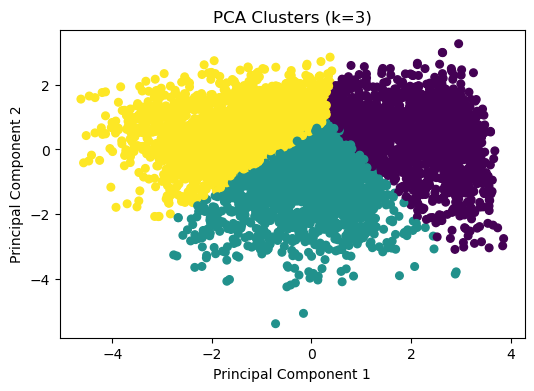

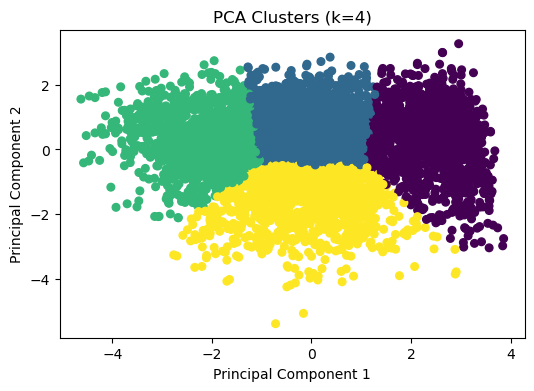

In [833]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Preprocessing (assuming df is already cleaned and categorical encoded) ---
numeric_df = df.select_dtypes(include=["float64", "int64"])

# Handle missing values
imputer = SimpleImputer(strategy="mean")
numeric_imputed = imputer.fit_transform(numeric_df)

# Scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_imputed)

# --- Apply PCA ---
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(scaled_data)

print("Explained variance ratio:", pca.explained_variance_ratio_)

# --- Run KMeans clustering for k=3 and k=4 ---
for k in [3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pca_data)

    # Plot PCA scatter with cluster labels
    plt.figure(figsize=(6, 4))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap="viridis", s=30)
    plt.title(f"PCA Clusters (k={k})")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()


Silhouette Score for 3 clusters: 0.093
Silhouette Score for 4 clusters: 0.088


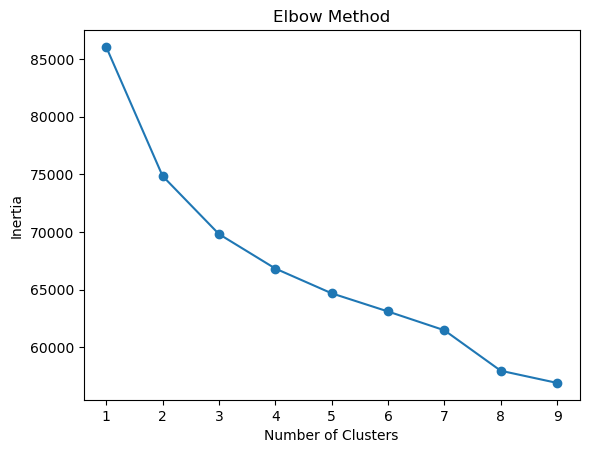

In [834]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# --- Load data ---
df = pd.read_csv("Users_Cards_merged.csv")

# --- Drop irrelevant or empty columns ---
cols_to_drop = ["expires", "has_chip", "acct_open_date", "age_group", "credit_limit"]
df = df.drop([c for c in cols_to_drop if c in df.columns], axis=1)

# --- Encode categorical variables ---
categorical_cols = ["card_brand", "card_type", "age_group_order", "credit_score_group"]
category_mappings = {}

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")
        category_mappings[col] = dict(enumerate(df[col].cat.categories))
        df[col] = df[col].cat.codes

# --- Select numeric columns ---
numeric_df = df.select_dtypes(include=["float64", "int64"])

# --- Handle missing values ---
imputer = SimpleImputer(strategy="mean")
numeric_imputed = imputer.fit_transform(numeric_df)

# --- Scale data ---
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_imputed)

# --- KMeans clustering for k=3 and k=4 ---
k_values = [3, 4]
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    df[f'cluster_{k}'] = kmeans.labels_

    silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
    print(f"Silhouette Score for {k} clusters: {silhouette_avg:.3f}")

# --- Elbow Method ---
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

